In [13]:
import zipfile
with zipfile.ZipFile('./drive/My Drive/Datasets/cifar10.zip', 'r') as zip:
  zip.extractall(path='./drive/My Drive/Datasets/')


KeyboardInterrupt: ignored

In [0]:
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
import keras
import pandas as pd
import numpy as np
from PIL import Image
import os
import warnings
warnings.filterwarnings('ignore')


In [0]:
labels = pd.read_csv('./drive/My Drive/Datasets/cifar10Labels.csv', index_col=0)
# View an image
img_idx = 5
print(labels.label[img_idx])
Image.open('./drive/My Drive/Datasets/cifar10/'+str(img_idx)+'.png')

In [0]:
# Splitting data into Train and Test data
from sklearn.model_selection import train_test_split
y_train, y_test = train_test_split(labels.label, test_size=0.3, random_state=42)
train_idx, test_idx = y_train.index, y_test.index # Stroing indexes for later use
# Reading images for training 
temp = []
for img_idx in y_train.index:
    img_path = os.path.join('./drive/My Drive/Datasets/cifar10/', str(img_idx) + '.png')
    img = np.array(Image.open(img_path)).astype('float32')        
    temp.append(img)    
X_train = np.stack(temp)
# Reading images for testing 
temp = []
for img_idx in y_test.index:
    img_path = os.path.join('./drive/My Drive/Datasets/cifar10/', str(img_idx) + '.png')
    img = np.array(Image.open(img_path)).astype('float32')        
    temp.append(img)
X_test = np.stack(temp)
# Normalizing image data
X_train = X_train/255.
X_test = X_test/255.


In [0]:
# One-hot encoding 10 output classes
encode_X = LabelEncoder()
encode_X_fit = encode_X.fit_transform(y_train)
y_train = keras.utils.np_utils.to_categorical(encode_X_fit)


In [0]:
# Defining CNN network
num_classes = 10
model = keras.models.Sequential([    
    # Adding first convolutional layer
    keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding='same', activation='relu', 
                        kernel_regularizer=keras.regularizers.l2(0.001), input_shape=(32, 32, 3), name='Conv_1'), 
    # Normalizing the parameters from last layer to speed up the performance (optional)
    keras.layers.BatchNormalization(name='BN_1'),
    # Adding first pooling layer
    keras.layers.MaxPool2D(pool_size=(2, 2), name='MaxPool_1'),
    # Adding second convolutional layer
    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='relu', 
                        kernel_regularizer=keras.regularizers.l2(0.001), name='Conv_2'),    
    keras.layers.BatchNormalization(name='BN_2'),
    # Adding second pooling layer
    keras.layers.MaxPool2D(pool_size=(2, 2), name='MaxPool_2'),
    # Flattens the input
    keras.layers.Flatten(name='Flat'),
    # Fully-Connected layer
    keras.layers.Dense(num_classes, activation='softmax', name='pred_layer')    
])


In [15]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_1 (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
BN_1 (BatchNormalization)    (None, 32, 32, 32)        128       
_________________________________________________________________
MaxPool_1 (MaxPooling2D)     (None, 16, 16, 32)        0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 16, 16, 64)        18496     
_________________________________________________________________
BN_2 (BatchNormalization)    (None, 16, 16, 64)        256       
_________________________________________________________________
MaxPool_2 (MaxPooling2D)     (None, 8, 8, 64)          0         
_________________________________________________________________
Flat (Flatten)               (None, 4096)             

In [16]:
# Compiling the model
model.compile(loss='categorical_crossentropy', 
              optimizer=keras.optimizers.Adam(), 
              metrics=['accuracy'])
cpfile = r'CIFAR10_checkpoint.hdf5' # Weights to be stored in HDF5 format
cb_checkpoint = keras.callbacks.ModelCheckpoint(cpfile, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
epochs = 5
model.fit(X_train, y_train, epochs=epochs, validation_split=0.2, callbacks=[cb_checkpoint])


Train on 28000 samples, validate on 7000 samples
Epoch 1/5
28000/28000 [==============================] - 66s 2ms/step - loss: 0.8219 - accuracy: 0.7337 - val_loss: 1.1610 - val_accuracy: 0.6501
Epoch 2/5
28000/28000 [==============================] - 65s 2ms/step - loss: 0.7380 - accuracy: 0.7624 - val_loss: 1.2559 - val_accuracy: 0.6309
Epoch 3/5
28000/28000 [==============================] - 65s 2ms/step - loss: 0.6762 - accuracy: 0.7837 - val_loss: 1.4264 - val_accuracy: 0.5904
Epoch 4/5
28000/28000 [==============================] - 64s 2ms/step - loss: 0.6318 - accuracy: 0.8015 - val_loss: 1.2560 - val_accuracy: 0.6473
Epoch 5/5
28000/28000 [==============================] - 64s 2ms/step - loss: 0.5864 - accuracy: 0.8188 - val_loss: 1.4006 - val_accuracy: 0.6269


In [17]:
# << DeprecationWarning: The truth value of an empty array is ambiguous >> can arise due to a NumPy version higher than 1.13.3.
# The issue will be updated in upcoming version.
pred = encode_X.inverse_transform(model.predict_classes(X_test[:10])) 
act = y_test[:10]
res = pd.DataFrame([pred, act]).T
res.columns = ['predicted', 'actual']
res


,predicted,actual
0,cat,horse
1,ship,ship
2,airplane,airplane
3,frog,frog
4,truck,automobile
5,frog,frog
6,ship,ship
7,truck,airplane
8,deer,frog
9,truck,dog


In [18]:
from mlxtend.evaluate import scoring
train_acc = scoring(encode_X.inverse_transform(model.predict_classes(X_train)),
                   encode_X.inverse_transform([np.argmax(x) for x in y_train]))
test_acc = scoring(encode_X.inverse_transform(model.predict_classes(X_test)), y_test)
print('Train accuracy: ', np.round(train_acc, 5))
print('Test accuracy: ', np.round(test_acc, 5))


Train accuracy:  0.23063
Test accuracy:  0.36453


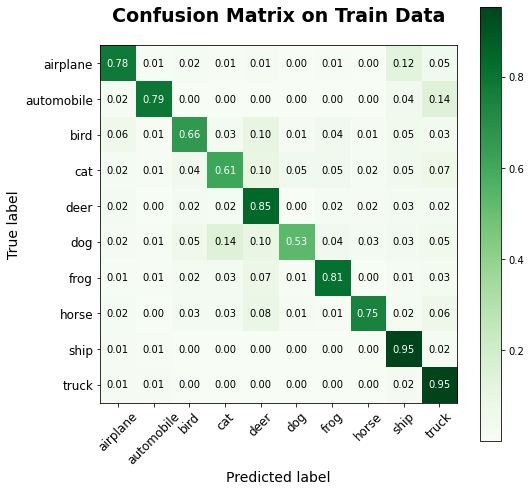

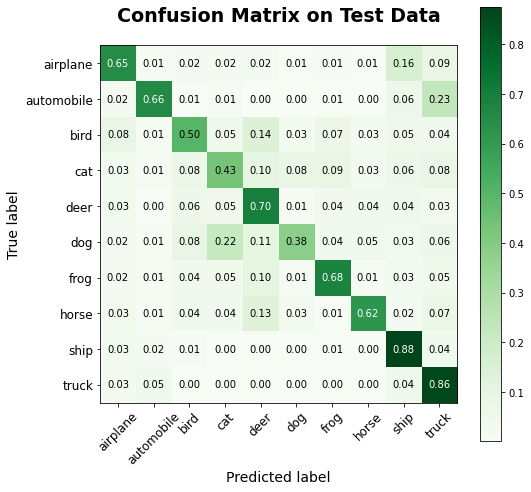

In [19]:
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
def plot_cm(cm, text):    
    class_names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    plot_confusion_matrix(conf_mat=cm, 
                          colorbar=True, figsize=(8, 8), cmap='Greens',
                          show_absolute=False, show_normed=True)
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45, fontsize=12)
    plt.yticks(tick_marks, class_names, fontsize=12)
    plt.xlabel('Predicted label', fontsize=14)
    plt.ylabel('True label', fontsize=14)
    plt.title(text, fontsize=19, weight='bold')
    plt.show()
# Train Accuracy    
train_cm = confusion_matrix(y_target=encode_X.inverse_transform([np.argmax(x) for x in y_train]), 
                          y_predicted=encode_X.inverse_transform(model.predict_classes(X_train)), 
                          binary=False)
plot_cm(train_cm, 'Confusion Matrix on Train Data')
# Test Accuracy
test_cm = confusion_matrix(y_target=y_test, 
                          y_predicted=encode_X.inverse_transform(model.predict_classes(X_test)), 
                          binary=False)
plot_cm(test_cm, 'Confusion Matrix on Test Data')


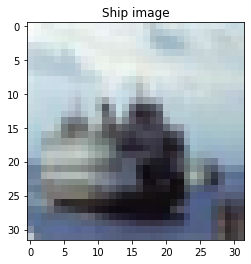

In [27]:

# from vis.visualization import visualize_saliency, visualize_cam, overlay
from vis.utils import utils
# Indexes of categories for our model
classes = encode_X.inverse_transform(np.arange(10))
classes
# array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog',
#        'horse', 'ship', 'truck'], dtype=object)
# Fetching the ship image
ship_img = utils.load_img('./drive/My Drive/Datasets/cifar10/'+str(test_idx[6])+'.png') # can use Image.open() also.
plt.imshow(ship_img)
plt.title('Ship image')
plt.show()


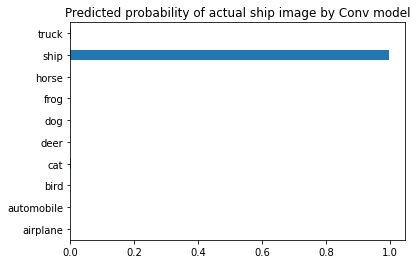

In [28]:
# Predicting the probability for each of the class

ship_prob = model.predict(X_test[6:7]).ravel().copy()
pd.Series(ship_prob, index=classes).plot.barh()
plt.title('Predicted probability of actual ship image by Conv model')
plt.show()


In [0]:
# Utility to search for layer index by name. 
layer_idx = utils.find_layer_idx(model, 'pred_layer')
# Swap softmax with linear
model.layers[layer_idx].activation = keras.activations.linear
model = utils.apply_modifications(model)


In [36]:
num_classes = 10
model = keras.models.Sequential([    
    # Adding first convolutional layer
    keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=2, padding='same', activation='relu', 
                        kernel_regularizer=keras.regularizers.l2(0.001), input_shape=(32, 32, 3), name='Conv_1'), 
    # Normalizing the parameters from last layer to speed up the performance (optional)
    keras.layers.BatchNormalization(name='BN_1'),
    # Adding first pooling layer
    keras.layers.MaxPool2D(pool_size=(2, 2), name='MaxPool_1'),
    # Adding second convolutional layer
    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=2, padding='same', activation='relu', 
                        kernel_regularizer=keras.regularizers.l2(0.001), name='Conv_2'),    
    keras.layers.BatchNormalization(name='BN_2'),
    # Adding second pooling layer
    keras.layers.MaxPool2D(pool_size=(2, 2), name='MaxPool_2'),
    # Flattens the input
    keras.layers.Flatten(name='Flat'),
    # Fully-Connected layer
    keras.layers.Dense(num_classes, activation='softmax', name='pred_layer')    
])
model.compile(loss='categorical_crossentropy', 
              optimizer=keras.optimizers.Adam(), 
              metrics=['accuracy'])
cpfile = r'CIFAR10_checkpoint_stride_2.hdf5' # Weights to be stored in HDF5 format
cb_checkpoint = keras.callbacks.ModelCheckpoint(cpfile, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
epochs = 5
model.fit(X_train, y_train, epochs=epochs, validation_split=0.2, callbacks=[cb_checkpoint])
from mlxtend.evaluate import scoring
actual_train = [np.argmax(x) for x in y_train]
predicted_train = model.predict_classes(X_train)
print('Train accuracy: ', scoring(actual_train, predicted_train, metric='accuracy') * 100) # Change metric for more.
actual_test = [np.argmax(x) for x in y_test]
predicted_test = model.predict_classes(X_test)
print('Test accuracy: ', scoring(actual_test, predicted_test, metric='accuracy') * 100) # Change metric for more.


Train on 28000 samples, validate on 7000 samples
Epoch 1/5
28000/28000 [==============================] - 16s 557us/step - loss: 1.6901 - accuracy: 0.4220 - val_loss: 1.5691 - val_accuracy: 0.4630
Epoch 2/5
28000/28000 [==============================] - 13s 478us/step - loss: 1.3563 - accuracy: 0.5363 - val_loss: 1.5704 - val_accuracy: 0.4657
Epoch 3/5
28000/28000 [==============================] - 13s 475us/step - loss: 1.2325 - accuracy: 0.5832 - val_loss: 1.4984 - val_accuracy: 0.5014
Epoch 4/5
28000/28000 [==============================] - 13s 474us/step - loss: 1.1507 - accuracy: 0.6160 - val_loss: 1.4069 - val_accuracy: 0.5356
Epoch 5/5
28000/28000 [==============================] - 13s 477us/step - loss: 1.0958 - accuracy: 0.6381 - val_loss: 1.4134 - val_accuracy: 0.5473
Train accuracy:  60.502857142857145
Test accuracy:  4.9


In [37]:
num_classes = 10
model = keras.models.Sequential([    
    # Adding first convolutional layer
    keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=3, padding='same', activation='relu', 
                        kernel_regularizer=keras.regularizers.l2(0.001), input_shape=(32, 32, 3), name='Conv_1'), 
    # Normalizing the parameters from last layer to speed up the performance (optional)
    keras.layers.BatchNormalization(name='BN_1'),
    # Adding first pooling layer
    keras.layers.MaxPool2D(pool_size=(2, 2), name='MaxPool_1'),
    # Adding second convolutional layer
    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=3, padding='same', activation='relu', 
                        kernel_regularizer=keras.regularizers.l2(0.001), name='Conv_2'),    
    keras.layers.BatchNormalization(name='BN_2'),
    # Adding second pooling layer
    keras.layers.MaxPool2D(pool_size=(2, 2), name='MaxPool_2'),
    # Flattens the input
    keras.layers.Flatten(name='Flat'),
    # Fully-Connected layer
    keras.layers.Dense(num_classes, activation='softmax', name='pred_layer')    
])
model.compile(loss='categorical_crossentropy', 
              optimizer=keras.optimizers.Adam(), 
              metrics=['accuracy'])
cpfile = r'CIFAR10_checkpoint_stride_3.hdf5' # Weights to be stored in HDF5 format
cb_checkpoint = keras.callbacks.ModelCheckpoint(cpfile, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
epochs = 5
model.fit(X_train, y_train, epochs=epochs, validation_split=0.2, callbacks=[cb_checkpoint])
actual_train = [np.argmax(x) for x in y_train]
predicted_train = model.predict_classes(X_train)
print('Train accuracy: ', scoring(actual_train, predicted_train, metric='accuracy') * 100) # Change metric for more.
actual_test = [np.argmax(x) for x in y_test]
predicted_test = model.predict_classes(X_test)
print('Test accuracy: ', scoring(actual_test, predicted_test, metric='accuracy') * 100) # Change metric for more.


Train on 28000 samples, validate on 7000 samples
Epoch 1/5
28000/28000 [==============================] - 8s 301us/step - loss: 1.7596 - accuracy: 0.4023 - val_loss: 1.6651 - val_accuracy: 0.4241
Epoch 2/5
28000/28000 [==============================] - 8s 283us/step - loss: 1.4509 - accuracy: 0.5039 - val_loss: 1.5123 - val_accuracy: 0.4819
Epoch 3/5
28000/28000 [==============================] - 8s 285us/step - loss: 1.3605 - accuracy: 0.5362 - val_loss: 1.5739 - val_accuracy: 0.4739
Epoch 4/5
28000/28000 [==============================] - 8s 286us/step - loss: 1.3047 - accuracy: 0.5609 - val_loss: 1.4230 - val_accuracy: 0.5207
Epoch 5/5
28000/28000 [==============================] - 8s 281us/step - loss: 1.2494 - accuracy: 0.5814 - val_loss: 1.8206 - val_accuracy: 0.4089
Train accuracy:  45.917142857142856
Test accuracy:  3.18


In [38]:
num_classes = 10
model = keras.models.Sequential([    
    # Adding first convolutional layer
    keras.layers.Conv2D(filters=32, kernel_size=(2, 2), strides=1, padding='same', activation='relu', 
                        kernel_regularizer=keras.regularizers.l2(0.001), input_shape=(32, 32, 3), name='Conv_1'), 
    # Normalizing the parameters from last layer to speed up the performance (optional)
    keras.layers.BatchNormalization(name='BN_1'),
    # Adding first pooling layer
    keras.layers.MaxPool2D(pool_size=(2, 2), name='MaxPool_1'),
    # Adding second convolutional layer
    keras.layers.Conv2D(filters=64, kernel_size=(2, 2), strides=1, padding='same', activation='relu', 
                        kernel_regularizer=keras.regularizers.l2(0.001), name='Conv_2'),    
    keras.layers.BatchNormalization(name='BN_2'),
    # Adding second pooling layer
    keras.layers.MaxPool2D(pool_size=(2, 2), name='MaxPool_2'),
    # Flattens the input
    keras.layers.Flatten(name='Flat'),
    # Fully-Connected layer
    keras.layers.Dense(num_classes, activation='softmax', name='pred_layer')    
])
model.compile(loss='categorical_crossentropy', 
              optimizer=keras.optimizers.Adam(), 
              metrics=['accuracy'])
cpfile = r'CIFAR10_checkpoint_filter_2.hdf5' # Weights to be stored in HDF5 format
cb_checkpoint = keras.callbacks.ModelCheckpoint(cpfile, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
epochs = 5
model.fit(X_train, y_train, epochs=epochs, validation_split=0.2, callbacks=[cb_checkpoint])
actual_train = [np.argmax(x) for x in y_train]
predicted_train = model.predict_classes(X_train)
print('Train accuracy: ', scoring(actual_train, predicted_train, metric='accuracy') * 100) # Change metric for more.
actual_test = [np.argmax(x) for x in y_test]
predicted_test = model.predict_classes(X_test)
print('Test accuracy: ', scoring(actual_test, predicted_test, metric='accuracy') * 100) # Change metric for more.


Train on 28000 samples, validate on 7000 samples
Epoch 1/5
28000/28000 [==============================] - 53s 2ms/step - loss: 1.7041 - accuracy: 0.4738 - val_loss: 1.4170 - val_accuracy: 0.5421
Epoch 2/5
28000/28000 [==============================] - 52s 2ms/step - loss: 1.2377 - accuracy: 0.5978 - val_loss: 1.6472 - val_accuracy: 0.5164
Epoch 3/5
28000/28000 [==============================] - 52s 2ms/step - loss: 1.0684 - accuracy: 0.6490 - val_loss: 1.2847 - val_accuracy: 0.5867
Epoch 4/5
28000/28000 [==============================] - 51s 2ms/step - loss: 0.9604 - accuracy: 0.6810 - val_loss: 1.3448 - val_accuracy: 0.5786
Epoch 5/5
28000/28000 [==============================] - 52s 2ms/step - loss: 0.8873 - accuracy: 0.7061 - val_loss: 1.1635 - val_accuracy: 0.6307
Train accuracy:  71.05142857142857
Test accuracy:  10.299999999999999


In [39]:
num_classes = 10
model = keras.models.Sequential([    
    # Adding first convolutional layer
    keras.layers.Conv2D(filters=32, kernel_size=(4, 4), strides=1, padding='same', activation='relu', 
                        kernel_regularizer=keras.regularizers.l2(0.001), input_shape=(32, 32, 3), name='Conv_1'), 
    # Normalizing the parameters from last layer to speed up the performance (optional)
    keras.layers.BatchNormalization(name='BN_1'),
    # Adding first pooling layer
    keras.layers.MaxPool2D(pool_size=(2, 2), name='MaxPool_1'),
    # Adding second convolutional layer
    keras.layers.Conv2D(filters=64, kernel_size=(4, 4), strides=1, padding='same', activation='relu', 
                        kernel_regularizer=keras.regularizers.l2(0.001), name='Conv_2'),    
    keras.layers.BatchNormalization(name='BN_2'),
    # Adding second pooling layer
    keras.layers.MaxPool2D(pool_size=(2, 2), name='MaxPool_2'),
    # Flattens the input
    keras.layers.Flatten(name='Flat'),
    # Fully-Connected layer
    keras.layers.Dense(num_classes, activation='softmax', name='pred_layer')    
])
model.compile(loss='categorical_crossentropy', 
              optimizer=keras.optimizers.Adam(), 
              metrics=['accuracy'])
cpfile = r'CIFAR10_checkpoint_filter_4.hdf5' # Weights to be stored in HDF5 format
cb_checkpoint = keras.callbacks.ModelCheckpoint(cpfile, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
epochs = 5
model.fit(X_train, y_train, epochs=epochs, validation_split=0.2, callbacks=[cb_checkpoint])
actual_train = [np.argmax(x) for x in y_train]
predicted_train = model.predict_classes(X_train)
print('Train accuracy: ', scoring(actual_train, predicted_train, metric='accuracy') * 100) # Change metric for more.
actual_test = [np.argmax(x) for x in y_test]
predicted_test = model.predict_classes(X_test)
print('Test accuracy: ', scoring(actual_test, predicted_test, metric='accuracy') * 100) # Change metric for more.


Train on 28000 samples, validate on 7000 samples
Epoch 1/5
28000/28000 [==============================] - 87s 3ms/step - loss: 1.7797 - accuracy: 0.4559 - val_loss: 2.2403 - val_accuracy: 0.3756
Epoch 2/5
28000/28000 [==============================] - 87s 3ms/step - loss: 1.2832 - accuracy: 0.5897 - val_loss: 1.9238 - val_accuracy: 0.4453
Epoch 3/5
28000/28000 [==============================] - 87s 3ms/step - loss: 1.0900 - accuracy: 0.6475 - val_loss: 1.2335 - val_accuracy: 0.6014
Epoch 4/5
28000/28000 [==============================] - 86s 3ms/step - loss: 0.9617 - accuracy: 0.6867 - val_loss: 1.6530 - val_accuracy: 0.5146
Epoch 5/5
28000/28000 [==============================] - 86s 3ms/step - loss: 0.8927 - accuracy: 0.7152 - val_loss: 1.1874 - val_accuracy: 0.6244
Train accuracy:  70.50857142857143
Test accuracy:  9.986666666666668
